<a href="https://colab.research.google.com/github/rhobaker/Data_Project/blob/main/Main_Jupyter_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [329]:
# Import all libraries needed for the project
import requests as requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

# Introduction to the project

The aim of our project was originally to examine the evidence that a proposed bill being put before the UK Parliament will be effective in reducing smoking rates in the UK.

The long title of this bill was:

> A Bill to Make provision about the supply of tobacco, vapes and other products, including provision prohibiting the sale of tobacco to people born on or after 1 January 2009; and to enable product requirements to be imposed in connection with tobacco, vapes and other products.

https://bills.parliament.uk/bills/3703

The Bill was set to prohibit the sale of cigarettes to people born after 2008.  Each year the age at which people can legally buy cigarettes will increase, resulting in people born after 31st December 2008 never being able to buy them.  The government believed that this would reduce the harm caused by smoking, which is still the number one cause of preventable deaths in the UK and costs the NHS £17bn a year.

However, the Prime Minister called a general election on 22nd May to be held on the 4th July.  The proposed bill did not come into law before this happened.  The focus of our project has therefore changed slightly to examine the evidence that future prevention strategies implemented by the next government will be effective in further reducing smoking rates.

https://www.bbc.co.uk/news/health-68825322#:~:text=The%20restrictions%20will%20apply%20to,able%20to%20legally%20buy%20cigarettes.

https://www.bbc.co.uk/news/uk-politics-69058303



To analyse how effective this ban might be we used evidence from a number of data sources to answer the questions:

### **How effective does historic data suggest that government mitigations have been on affecting smoking prevalence?**

### **Based on this analysis, how effective will the new ban be on reducing smoking prevalence?**



## Data Cleaning

#### Data cleaning for ONS Adult smoking habits in Great Britain: Table 1a: Proportion of cigarette smokers, by sex and age, Great Britain, 1974 to 2022


In [330]:
#Load the data into a dataframe and view a sample
url=("https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_adult_smoking_habits_in_great_britain/Table_1a-Table%201.csv")
table1a = pd.read_csv(url)
# table1a.head()

In [331]:
#Explore the data
#View table size
table1a.shape

#View information on all columns in the dataframe
# table1a.info(verbose=True)

(36, 21)

In [332]:
#Check the column names
sorted(table1a)

# We can see column 20 is an unnamed blank column. Drop this column
table1a.drop(table1a.columns[table1a.columns.str.contains('Unnamed')], axis=1, inplace=True)

#Check column dropped
#sorted(table1a)

In [333]:
#Many of the column names are long, rename them to shorter names
#View columns in order first
table1a.columns
table1a.columns = ["Weight", "Year", "Men 16-24", "Men 25-34", "Men 35-49", "Men 50-59", "Men 60+", "All men 16+",
                  "Women 16-14", "Women 25-34", "Women 35-49", "Women 50-59", "Women 60+", "All women 16+",
                  "All 16-24", "All 25-34", "All 35-49", "All 50-59", "All 60+", "All 16+"]
# table1a.head()

In [334]:
#The 'Year' column refers to notes, remove these so that the column just shows year values
#import regex
import re

#Use regex extract to set the values to a string beginning with four digits
table1a['Year'] = table1a['Year'].str.extract(r'^(\d{4})', expand=False)

#Check the column now only shows the year values
# table1a['Year']

In [335]:
#Check for missing values and duplicates
missing = table1a.isnull().sum()
# print(missing)

duplicates = table1a.duplicated().sum()
# print(duplicates)

#No duplicates or missing, no further action needed. In this dataset, duplicates would not be removed, but should be considered.

In [336]:
#Normalise data types
#Check data types
table1a.dtypes

#All the columns showing proportion are float data type, which is correct.
#After our filtering we need to change the 'Year' column to int data type
table1a['Year'] = table1a['Year'].astype('int64')

#Check
# table1a.dtypes

In [337]:
#Explore the proportional numeric data
table1a.describe()

#.describe() for the whole table is overwhelming - view summary statistics just for total men, total women, and all people (over 16)
table1a[["All men 16+", "All women 16+", "All 16+"]].describe()

,All men 16+,All women 16+,All 16+
count,36.000000,36.000000,36.000000
mean,26.713889,23.469444,25.005556
std,9.291783,7.857001,8.457961
min,12.500000,10.000000,11.200000
25%,20.775000,17.100000,19.100000
50%,25.850000,22.850000,24.250000
75%,29.800000,27.975000,28.800000
max,51.400000,40.700000,45.600000


Our quartiles are fairly evenly spread here, with the mean sitting near the median, however our maximum values are significantly above the third quartiles. The proportion of women is lower overall, with men skewing the average rate slightly higher. This data is however aggregating the proportion of smokers over time, so these extreme spread is unlikely to show outliers, but rather differences in the smoking rate over time at the extreme ends (earliest date and latest date). We can do a quick filter to confirm this:


In [338]:
#We can filter to look at values at the higher and lower end to see where they lie:
table1a[table1a['All 16+'] > 40]
#The higher values are in the 1970s, as expected.

table1a[table1a['All 16+'] < 15]
#The lower values are in the 2020s, as expected.

,Weight,Year,Men 16-24,Men 25-34,Men 35-49,Men 50-59,Men 60+,All men 16+,Women 16-14,Women 25-34,Women 35-49,Women 50-59,Women 60+,All women 16+,All 16-24,All 25-34,All 35-49,All 50-59,All 60+,All 16+
0,Weighted,2022,9.9,14.4,13.7,17.3,9.0,12.5,11.0,13.3,10.0,12.5,6.8,10.0,10.5,13.8,11.8,14.9,7.9,11.2
1,Weighted,2021,13.5,17.4,16.3,16.1,8.4,13.7,12.7,16.1,13.3,13.6,7.0,11.7,13.1,16.8,14.8,14.8,7.7,12.7
2,Weighted,2020,15.9,18.4,18.7,16.4,9.8,15.3,14.4,17.9,15.1,16.1,9.1,13.7,15.2,18.1,16.9,16.3,9.4,14.5


In [339]:
#Write the cleaned data to a new csv
# table1a.to_csv('smokinghabits_Table_1a-Table_1_cleaned.csv', encoding='utf-8')

#### ONS E-cigarette use in Great Britain: Table 1: E-cigarette use as proportion of population 16+, by sex and age, Great Britain, 2014 to 2022

- Table 1a: 2020 to 2022 - Table 1b: 2018 to 2019 - Table 1c: 2014 to 2017

We need to merge the three tables to have the data on e-cig use from 2014-2022 in one set.

Data caveats: Notes with the data state that changes in survey questions across time affected the continuity of data on ex-vapers. Due to this unreliability of the data, as our project only requires prevalence of current e-cigarette smokers, we will extract only the data on current users and ignore the other classifications. Notes state that the categories for current users changed between 2019 and 2020: the sum of the newer categories of 'daily user' and 'occasional user' equates to the single previous category of 'current user'. This is acceptable for continuity. In table1a where this applies we will sum these rows.

In [340]:
#Table 1a
url=("https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_ecigarette_use_in_great_britain/Table_1a-Table%201.csv")
table1a = pd.read_csv(url, header=1)
# table1a.head(15)

In [341]:
#We can see 2022 daily and occasional users are at index 0 and 1, 2021 are at index 6 and 7, and 2020 are at index 12 and 13.
#Extract and concatenate these
table1a = pd.concat([table1a.loc[0:1], table1a.loc[6:7], table1a.loc[12:13]])

# table1a.head()
#reset the index
table1a.reset_index(drop=True)

,Year,Proportion of population aged 16 years and over by e-cigarette use [note 1],Men \naged \n16 to 24,Men \naged \n25 to 34,Men \naged \n35 to 49,Men \naged \n50 to 59,Men \naged \n60 and over,Men \naged \n16 and over,Women \naged \n16 to 24,Women \naged \n25 to 34,Women \naged \n35 to 49,Women \naged \n50 to 59,Women \naged \n60 and over,Women \naged \n16 and over,All persons \naged \n16 to 24,All persons \naged \n25 to 34,All persons \naged \n35 to 49,All persons \naged \n50 to 59,All persons \naged \n60 and over,All persons \naged \n16 and over
0,2022,Daily user (%),3.6,7.4,8.2,7.4,3.7,6.0,6.7,6.2,4.9,4.9,2.2,4.4,5.1,6.8,6.5,6.1,2.9,5.2
1,2022,Occasional user (%),8.7,4.2,3.5,2.5,1.4,3.5,12.2,3.5,2.6,2.3,1.5,3.5,10.4,3.8,3.0,2.4,1.5,3.5
2,2021,Daily user (%),5.1,11.3,7.7,5.3,4.2,6.4,1.9,5.4,3.8,5.8,1.8,3.5,3.6,8.3,5.7,5.6,2.9,4.9
3,2021,Occasional user (%),7.9,2.0,4.3,2.6,1.6,3.3,7.1,3.0,1.9,1.4,0.6,2.2,7.5,2.5,3.1,2.0,1.1,2.8
4,2020,Daily user (%),4.1,4.6,7.0,6.6,2.1,4.7,1.6,4.4,2.9,4.9,1.9,3.0,2.9,4.5,5.0,5.7,2.0,3.8
5,2020,Occasional user (%),5.0,4.3,2.2,1.5,1.2,2.5,3.1,3.9,2.7,2.8,1.7,2.6,4.1,4.1,2.5,2.2,1.5,2.6


In [342]:
#Combine the rows for daily and occasional user for each year
 #First check the datatypes
table1a.dtypes

#The values are numbers, change numeric columns to float values
numeric_columns = ['Men \naged \n16 to 24',	'Men \naged \n25 to 34', 'Men \naged \n35 to 49', 'Men \naged \n50 to 59', 'Men \naged \n60 and over', 'Men \naged \n16 and over', 'Women \naged \n16 to 24', 'Women \naged \n25 to 34', 'Women \naged \n35 to 49', 'Women \naged \n50 to 59', 'Women \naged \n60 and over', 'Women \naged \n16 and over', 'All persons \naged \n16 to 24',	'All persons \naged \n25 to 34', 'All persons \naged \n35 to 49', 'All persons \naged \n50 to 59', 'All persons \naged \n60 and over', 'All persons \naged \n16 and over']
table1a[numeric_columns] = table1a[numeric_columns].astype(float)
#Check
#table1a.dtypes

In [343]:
#Combine the values in the daily and occasional user columns using the group by, aggregate and sum functions
table1a = table1a.groupby('Year').agg(sum)
# table1a.head()

In [344]:
#Re-sort to descending year order
table1a_sorted = table1a.sort_values(by = 'Year', ascending=False)

#Reset the index
table1a_sorted.reset_index()

,Year,Proportion of population aged 16 years and over by e-cigarette use [note 1],Men \naged \n16 to 24,Men \naged \n25 to 34,Men \naged \n35 to 49,Men \naged \n50 to 59,Men \naged \n60 and over,Men \naged \n16 and over,Women \naged \n16 to 24,Women \naged \n25 to 34,Women \naged \n35 to 49,Women \naged \n50 to 59,Women \naged \n60 and over,Women \naged \n16 and over,All persons \naged \n16 to 24,All persons \naged \n25 to 34,All persons \naged \n35 to 49,All persons \naged \n50 to 59,All persons \naged \n60 and over,All persons \naged \n16 and over
0,2022,Daily user (%)Occasional user (%),12.3,11.6,11.7,9.9,5.1,9.5,18.9,9.7,7.5,7.2,3.7,7.9,15.5,10.6,9.5,8.5,4.4,8.7
1,2021,Daily user (%)Occasional user (%),13.0,13.3,12.0,7.9,5.8,9.7,9.0,8.4,5.7,7.2,2.4,5.7,11.1,10.8,8.8,7.6,4.0,7.7
2,2020,Daily user (%)Occasional user (%),9.1,8.9,9.2,8.1,3.3,7.2,4.7,8.3,5.6,7.7,3.6,5.6,7.0,8.6,7.5,7.9,3.5,6.4


In [345]:
#Table1b
url=("https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_ecigarette_use_in_great_britain/Table_1b-Table%201.csv")
table1b = pd.read_csv(url, header=1)
# table1b.head(15)

#We can see that 2019 current users is at index 0 and 2018 is at index 7, extract these rows
table1b = table1b[0:7:6]
# table1b.head()

In [346]:
#Table 1c
url=("https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_ecigarette_use_in_great_britain/Table_1c-Table%201.csv")
table1c = pd.read_csv(url)
table1c.head(15)

#The current user rows start at 0 and end at 18 in increments of 6, extract these rows
table1c = table1c.loc[0:18:6]
# table1c.head()

In [347]:
#Concatenate tables 1a, 1b and 1c vertically to combine them
table1 = pd.concat([table1a_sorted, table1b, table1c], axis=0)

#reset the index
table1.reset_index(drop=True, inplace=True)

#View and check full table
#table1

In [348]:
#Explore the data
#View table size
table1.shape

#View information on all columns in the dataframe
# table1.info(verbose=True)

(9, 20)

In [349]:
#Remove the current user column
table1.drop(['Proportion of population aged 16 years and over by e-cigarette use [note 1]'], axis=1, inplace=True)
# table1.head()

In [350]:
#View and rename table columns to be more concise
table1.columns
table1.columns = ["Year", "Men 16-24", "Men 25-34", "Men 35-49", "Men 50-59", "Men 60+", "All men 16+",
                  "Women 16-14", "Women 25-34", "Women 35-49", "Women 50-59", "Women 60+", "All women 16+",
                  "All 16-24", "All 25-34", "All 35-49", "All 50-59", "All 60+", "All 16+"]
# table1.head()

In [351]:
#Check for missing values and duplicates
missing = table1.isnull().sum()
# print(missing)

duplicates = table1.duplicated().sum()
# print(duplicates)
#None, no further action needed

In [352]:
#Normalise data types
#Check data types
table1.dtypes

# All the columns showing proportion are object data type, we need to change these to float
# Extract the float columns and apply type change
float_columns = table1.select_dtypes(include='object').columns
table1[float_columns] = table1[float_columns].astype("float")

# Check
# table1.dtypes

In [353]:
#Explore the proportional numeric data
table1.describe()

#.describe() for the whole table is overwhelming - view summary statistics just for total age groups and general total
table1[["All 16-24", "All 25-34", "All 35-49", "All 50-59", "All 60+", "All 16+"]].describe()

,All 16-24,All 25-34,All 35-49,All 50-59,All 60+,All 16+
count,9.000000,9.000000,9.000000,9.000000,9.000000,6.000000
mean,7.944444,7.577778,6.477778,3.333333,6.011111,2016.500000
std,1.974912,1.196639,1.584123,0.803119,1.519411,1.870829
min,5.300000,5.600000,3.500000,2.100000,3.700000,2014.000000
25%,6.900000,7.100000,5.400000,2.900000,5.500000,2015.250000
50%,7.300000,7.400000,6.800000,3.100000,5.700000,2016.500000
75%,9.200000,8.500000,7.600000,4.000000,6.400000,2017.750000
max,10.800000,9.500000,8.500000,4.400000,8.700000,2019.000000


We can see that the data is skewing high in several of the age groups, with the range between the second and third quartiles higher than the range between the 1st and 2nd quartile, with most of the means sitting above the median. As we are looking at data over time, this liekly correlates with a steeper increase rate in use over time. We can see in the youngest age group that the maximum value is over double the third quartile.

We must consider that the survey question changes after 2019, although with reported acceptable continuity, may have caused an outlier value here; however because all other age groups do not have a high outlier, and the rate in younger people is reported to have risen at a high rate, we will leave this data in and explore further in visualisation.

In [354]:
#Write the cleaned data to a new csv
# table1.to_csv('ecig_table1abc_cleaned.csv', encoding='utf-8')

#### Data cleaning for NHS datasets - Table S.3.1 regarding the affordability of tobacco in the UK, and Table S.3.2 regarding household expenditure on tobacco

**Table S.3.1**	Indices of tobacco price, retail prices, tobacco price index relative to retail prices index (all items), real disposable income per adult and affordability of tobacco in the United Kingdom

In [355]:
#load the data into a dataframe and view a sample

import pandas as pd
url1 = "https://raw.githubusercontent.com/rhobaker/Data_Project/main/NHS_smoking_eng_2020/Table%20S.3.1-Table%201.csv"
affordability = pd.read_csv(url1)
#affordability

In [356]:
url2 = "https://raw.githubusercontent.com/rhobaker/Data_Project/main/NHS_smoking_eng_2020/Table%20S.3.2-Table%201.csv"
expenditure = pd.read_csv(url2)
#expenditure

In [357]:
affordability.shape
affordability.info(verbose=True)
# #This dataset appear to be clean and in a workable condition

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 6 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Year                                                                  33 non-null     int64  
 1   Tobacco 
price
index (TPI)                                          33 non-null     float64
 2   Retail prices
index (RPI)
- all items                               33 non-null     float64
 3   Tobacco price 
index relative to 
Retail price index 
(all items)  33 non-null     float64
 4   Real 
households' disposable 
income 
index (RHDI)2                33 non-null     float64
 5   Affordability 
of tobacco 
index3                                   33 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 1.7 KB


In [358]:
# expenditure.shape
expenditure.info(verbose=True)
# #This dataset appears to have an unnamed column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 5 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Year                                                   35 non-null     int64  
 1   Household 
expenditure
on tobacco                    35 non-null     object 
 2   Total 
household 
expenditure                        35 non-null     object 
 3   Expenditure on 
tobacco as a 
percentage of 
total  35 non-null     float64
 4   Unnamed: 4                                             0 non-null      float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.5+ KB


In [359]:
#Check the column names
sorted(expenditure)

#We can see column 4 is an unnamed blank column - we'll drop this column
expenditure.drop(expenditure.columns[expenditure.columns.str.contains('Unnamed')], axis=1, inplace=True)

#Check that column has been dropped
sorted(expenditure)

['Expenditure on \r\ntobacco as a \r\npercentage of \r\ntotal',
 'Household \r\nexpenditure\r\non tobacco',
 'Total \r\nhousehold \r\nexpenditure',
 'Year']

In [360]:
#I want to directly compare the two datasets, but the expenditure dataset goes back to 1985
# while the affordability dataset only goes to 1987

#For comparison purposes I'll delete the first two rows from the expenditure dataset
expenditure.drop([0, 1], inplace=True)

#Check that rows have been dropped
#expenditure.head

In [361]:
expenditure.columns

#I want to shorten the column names for simplicity
expenditure.columns = ["Year", "Tobacco Expenditure", "Total Expenditure", "Tobacco Expenditure (%)"]

#expenditure.head(5)

In [362]:
#affordability.columns

#I'll again short the columns for the affordability dataset
affordability.columns = ["Year", "Tobacco Price Index", "Retail Price Index", "TPI relative RPI", "Real Household Disposable Income", "Tobacco Affordability Index"]
#affordability.head(6)

In [363]:
#Normalising data
expenditure.dtypes

#The tobacco and total expenditure columns in the expenditure dataset are string values, which aren't suitable for analysis
#First I'll remove non numeric values from the columns
expenditure['Tobacco Expenditure'] = expenditure['Tobacco Expenditure'].str.replace(",", "")
expenditure['Total Expenditure'] = expenditure['Total Expenditure'].str.replace(",", "")


In [364]:

#Then I'll convert the data from string to integer
expenditure["Tobacco Expenditure"] = expenditure["Tobacco Expenditure"].astype('int64')
expenditure["Total Expenditure"] = expenditure["Total Expenditure"].astype('int64')
expenditure.dtypes

Year                         int64
Tobacco Expenditure          int64
Total Expenditure            int64
Tobacco Expenditure (%)    float64
dtype: object

In [365]:
affordability.dtypes
#The affordability data does not need further normalisation

Year                                  int64
Tobacco Price Index                 float64
Retail Price Index                  float64
TPI relative RPI                    float64
Real Household Disposable Income    float64
Tobacco Affordability Index         float64
dtype: object

In [366]:
#Write the cleaned data to a new csv
affordability.to_csv()
expenditure.to_csv()

',Year,Tobacco Expenditure,Total Expenditure,Tobacco Expenditure (%)\n2,1987,7631,302328,2.5\n3,1988,7890,340363,2.3\n4,1989,8112,372485,2.2\n5,1990,8576,404595,2.1\n6,1991,9556,432980,2.2\n7,1992,10169,454983,2.2\n8,1993,10631,482302,2.2\n9,1994,10787,505805,2.1\n10,1995,11349,531720,2.1\n11,1996,12068,569892,2.1\n12,1997,12485,609395,2.0\n13,1998,13267,643490,2.1\n14,1999,14084,675094,2.1\n15,2000,14149,709941,2.0\n16,2001,14208,736203,1.9\n17,2002,14233,761930,1.9\n18,2003,15137,796620,1.9\n19,2004,15244,834577,1.8\n20,2005,15446,873475,1.8\n21,2006,15250,910681,1.7\n22,2007,15302,954366,1.6\n23,2008,15794,983503,1.6\n24,2009,16294,956293,1.7\n25,2010,17263,984357,1.8\n26,2011,18264,1021129,1.8\n27,2012,18758,1058472,1.8\n28,2013,18925,1109534,1.7\n29,2014,19856,1153351,1.7\n30,2015,19222,1187215,1.6\n31,2016,19112,1248091,1.5\n32,2017,19360,1287278,1.5\n33,2018,19914,1335216,1.5\n34,2019,19262,1364462,1.4\n'

####Data cleaned:
*   ONS average price of King size pack of cigarettes
*   Historic Tobacco Duty
*   IFS historic VAT rate





In [367]:
#Average price per year
file_path = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_av_price_cigarettes_king_size_filter/ONS_av_price_cigarettes_king_size_filter.csv'
price_df = pd.read_csv(file_path)

In [368]:
# Extract the year from the 'unit' column
price_df['year'] = price_df['Unit'].str[:4]

# Extract the month or quarter from the 'unit' column if it is present.
price_df['month'] = price_df['Unit'].str[4:]


# Convert the 'year' column to integer.
price_df['year'] = price_df['year'].astype(int)

# Group by year and calculate the maximum price.
max_price_per_year = price_df.groupby('year')['Pence'].max().reset_index()

#Write the cleaned data to a new csv
#max_price_per_year.to_csv('Cleaned_ONS_av_price_cigarettes_king_size_filterce_cigarettes_king_size.csv', encoding='utf-8')

In [369]:
#Tobacco Duty: Saved in two csv - one for pre 20 May 2017 and one post this date
# Load the CSV files
pre_may_2017_df = pd.read_csv('https://raw.githubusercontent.com/rhobaker/Data_Project/main/Historical%20Tobacco%20Duty%20rates/historical_tobacco_duty_pre_may_2017.csv')
post_may_2017_df = pd.read_csv('https://raw.githubusercontent.com/rhobaker/Data_Project/main/Historical%20Tobacco%20Duty%20rates/historical_tobacco_duty_post_may_2017.csv')

In [370]:
# Clean pre-May 2017 data
def clean_pre_may_2017(df):
    # Change 'Date of change' to datetime format
    df['Date of change'] = pd.to_datetime(df['Date of change'], format='%d %B %Y', errors='coerce')
    # Drop rows with invalid dates
    df = df.dropna(subset=['Date of change'])
    # Remove duplicates
    df = df.drop_duplicates(subset=['Date of change'], keep='last')
    # Check and handle missing values
    if df.isnull().values.any():
        df = df.fillna(method='ffill').fillna(method='bfill')
    return df

In [371]:
def clean_post_may_2017(df):
    # Change 'Date of change' to datetime format
    df['Date of change'] = pd.to_datetime(df['Date of change'], format='%d %B %Y', errors='coerce')
    # Drop rows with invalid dates
    df = df.dropna(subset=['Date of change'])
    # Remove duplicates
    df = df.drop_duplicates(subset=['Date of change'], keep='last')
    # Check and handle missing values
    if df.isnull().values.any():
        df = df.fillna(method='ffill').fillna(method='bfill')
    return df

In [372]:
clean_pre_may_2017_df = clean_pre_may_2017(pre_may_2017_df)

clean_post_may_2017_df = clean_post_may_2017(post_may_2017_df)

# Print the cleaned dataframes to verify
print(clean_pre_may_2017_df.head())

  Date of change  Cigarettes ad valorem (%)  Specific £ per 1000 sticks  \
0     1978-01-01                       30.0                        9.00   
1     1979-08-13                       21.0                       11.77   
2     1980-03-29                       21.0                       13.42   
3     1981-03-14                       21.0                       18.04   
4     1981-07-08                       21.0                       19.03   

   Cigars £ per kg  HRT £ per kg  Other £ per kg  
0            20.94         20.28           16.09  
1            20.94         20.28           16.09  
2            25.60         22.60           17.40  
3            34.29         29.56           21.92  
4            35.91         30.96           22.96  


In [373]:
#Write the cleaned data to a new csv
#max_price_per_year.to_csv('Cleaned_ONS_av_price_cigarettes_king_size_filterce_cigarettes_king_size.csv', encoding='utf-8')

In [374]:
# Load the CSV files
pre_may_2017_df = pd.read_csv('https://raw.githubusercontent.com/rhobaker/Data_Project/main/Cleaned_Data/clean_historical_tobacco_duty_pre_may_2017.csv')
post_may_2017_df = pd.read_csv('https://raw.githubusercontent.com/rhobaker/Data_Project/main/Cleaned_Data/clean_historical_tobacco_duty_post_may_2017.csv')

In [375]:
#Drop columns not needed
pre_may_2017_df.drop(columns=['Cigars £ per kg', 'HRT £ per kg', 'Other £ per kg'], inplace=True)
post_may_2017_df.drop(columns=['Cigars £ per kg', 'HRT £ per kg', 'Other £ per kg', 'TfH £ per kg'], inplace=True)

In [376]:
##Vat data cleaning
vat_url = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/Historical%20Tobacco%20Duty%20rates/IFS%20historic%20VAT%20-%20Sheet1.csv'
vat = pd.read_csv(vat_url)

In [377]:
# Drop columns no longer needed
vat = vat.drop(columns=['Reducedb', 'Highera', 'Registration threshold']).reset_index()

####ONS smoking habits in the uk and its constituent countries Table 9

In [378]:
# Load the CSV file
url = ("https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_smoking_habits_in_the_uk_and_its_constituent_countries/Table_9.csv")

data = pd.read_csv(url)

# Display the first few rows to understand its structure
# data

In [379]:
# Create a DataFrame to hold just the data for the total UK
total_pop_df = data[data['Country'] == "United Kingdom"]
# Clean the column names
total_pop_df.columns = data.columns.str.replace('\n', ' ').str.replace(' ', '_').str.replace('__', '_').str.replace(',','').str.strip()
# Select just the two columns needed and format columns
total_pop_df = total_pop_df[["Highest_level_of_education", "2022__Weighted_count_[note_2]"]]
total_pop_df = total_pop_df.rename(columns = {"2022__Weighted_count_[note_2]":"Total Population", "Highest_level_of_education":"Highest level of education"})
total_pop_df = total_pop_df.set_index("Highest level of education")
total_pop_df["Total Population"] = total_pop_df["Total Population"].str.replace(',','')
# Turn data into numeric values to calculate the %
total_pop_df["Total Population"] = total_pop_df["Total Population"].apply(pd.to_numeric, errors='coerce')
# Calculate %
total_pop_df["Total Population %"] = (total_pop_df["Total Population"]/total_pop_df["Total Population"].sum()) * 100
total_pop_df

,Total Population,Total Population %
Highest level of education,,
Degree or equivalent,15005943,37.007793
Higher education,2946090,7.265674
GCE A level or equivalent,9306449,22.951649
GCSE grades A*-C or equivalent,7155098,17.645968
Other qualification,3107031,7.662588
No qualifications,3027451,7.466327


In [380]:
# Clean the column names
data.columns = data.columns.str.replace('\n', ' ').str.replace(' ', '_').str.replace('__', '_').str.strip()
# print(data.columns.tolist())
['Country_code', 'Country', 'Highest_level_of_education', '2022_Current_smokers_%', '2022_Current_smokers_LCL', '2022_Current_smokers_UCL', '2022_Ex-smokers_%', '2022_Ex-smokers_LCL', '2022_Ex-smokers_UCL', '2022_Never_smoked_%', '2022_Never_smoked_LCL', '2022_Never_smoked_UCL', '2022__Weighted_count_[note_2]', '2022_Sample_size_[note_3]', '2021_Current_smokers_%', '2021_Current_smokers_LCL', '2021_Current_smokers_UCL', '2021_Ex-smokers_%', '2021_Ex-smokers_LCL', '2021_Ex-smokers_UCL', '2021_Never_smoked_%', '2021_Never_smoked_LCL', '2021_Never_smoked_UCL', '2021__Weighted_count_[note_2]', '2021_Sample_size_[note_3]', '2020_Current_smokers_%', '2020_Current_smokers_LCL', '2020_Current_smokers_UCL', '2020_Ex-smokers_%', '2020_Ex-smokers_LCL', '2020_Ex-smokers_UCL', '2020_Never_smoked_%', '2020_Never_smoked_LCL', '2020_Never_smoked_UCL', '2020_Weighted_count_[note_2]', '2020_Sample_size_[note_3]', '2019_Current_smokers_%', '2019_Current_smokers_LCL', '2019_Current_smokers_UCL', '2019_Ex-smokers_%', '2019_Ex-smokers_LCL', '2019_Ex-smokers_UCL', '2019_Never_smoked_%', '2019_Never_smoked_LCL', '2019_Never_smoked_UCL', '2019_Weighted_count_[note_2]', '2019_Sample_size_[note_3]', '2018_Current_smokers_%', '2018_Current_smokers_LCL', '2018_Current_smokers_UCL', '2018_Ex-smokers_%', '2018_Ex-smokers_LCL', '2018_Ex-smokers_UCL', '2018_Never_smoked_%', '2018_Never_smoked_LCL', '2018_Never_smoked_UCL', '2018_Weighted_count_[note_2]', '2018_Sample_size_[note_3]', '2017_Current_smokers_%', '2017_Current_smokers_LCL', '2017_Current_smokers_UCL', '2017_Ex-smokers_%', '2017_Ex-smokers_LCL', '2017_Ex-smokers_UCL', '2017_Never_smoked_%', '2017_Never_smoked_LCL', '2017_Never_smoked_UCL', '2017_Weighted_count_[note_2]', '2017_Sample_size_[note_3]', '2016_Current_smokers_%', '2016_Current_smokers_LCL', '2016_Current_smokers_UCL', '2016_Ex-smokers_%', '2016_Ex-smokers_LCL', '2016_Ex-smokers_UCL', '2016_Never_smoked_%', '2016_Never_smoked_LCL', '2016_Never_smoked_UCL', '2016_Weighted_count_[note_2]', '2016_Sample_size_[note_3]', '2015_Current_smokers_%', '2015_Current_smokers_LCL', '2015_Current_smokers_UCL', '2015_Ex-smokers_%', '2015_Ex-smokers_LCL', '2015_Ex-smokers_UCL', '2015_Never_smoked_%', '2015_Never_smoked_LCL', '2015_Never_smoked_UCL', '2015_Weighted_count_[note_2]', '2015_Sample_size_[note_3]', '2014_Current_smokers_%', '2014_Current_smokers_LCL', '2014_Current_smokers_UCL', '2014_Ex-smokers_%', '2014_Ex-smokers_LCL', '2014_Ex-smokers_UCL', '2014_Never_smoked_%', '2014_Never_smoked_LCL', '2014_Never_smoked_UCL', '2014_Weighted_count_[note_2]', '2014_Sample_size_[note_3]']
# Adjusted column names based on the inspection
columns_of_interest = [
    'Country', 'Highest_level_of_education',
    '2022_Current_smokers_%', '2022_Current_smokers_LCL', '2022_Current_smokers_UCL',
    '2022_Ex-smokers_%', '2022_Ex-smokers_LCL', '2022_Ex-smokers_UCL',
    '2022_Never_smoked_%', '2022_Never_smoked_LCL', '2022_Never_smoked_UCL'
]

# Select relevant columns for the year 2022
data_2022 = data[columns_of_interest].copy()
# data_2022

In [381]:
# Display the cleaned column names
# print(data.columns.tolist())

# Extract the years present in the dataset based on column names
years = list(set([col.split('_')[0] for col in data.columns if col.split('_')[0].isdigit()]))
# print("Years found in the dataset:", years)

# List of smoking status categories
smoking_statuses = ['Current_smokers_%', 'Ex-smokers_%', 'Never_smoked_%']

# Correct column names for melting
columns_to_melt = {}
for status in smoking_statuses:
    columns_to_melt[status] = [col for col in data.columns if status in col]

# print("Columns to melt for each status:", columns_to_melt)

# Initialize an empty list to store dataframes
dfs = []

# Loop through each smoking status to melt the data
for status, status_cols in columns_to_melt.items():
    status_df = data.melt(id_vars=['Country', 'Highest_level_of_education'],
                          value_vars=status_cols,
                          var_name='Year_Status',
                          value_name=status)

    # Extract year from the combined Year_Status column
    status_df['Year'] = status_df['Year_Status'].str.extract('(\d{4})').astype(int)

    # Drop the Year_Status column
    status_df = status_df.drop(columns=['Year_Status'])

    # Append the melted dataframe to the list
    dfs.append(status_df)

# Merge the dataframes on common columns
data_long = dfs[0]
for df in dfs[1:]:
    data_long = pd.merge(data_long, df, on=['Country', 'Highest_level_of_education', 'Year'])

#print(data_long.head()

In [382]:
# Convert percentage columns to numeric
percentage_columns = [
    '2022_Current_smokers_%', '2022_Current_smokers_LCL', '2022_Current_smokers_UCL',
    '2022_Ex-smokers_%', '2022_Ex-smokers_LCL', '2022_Ex-smokers_UCL',
    '2022_Never_smoked_%', '2022_Never_smoked_LCL', '2022_Never_smoked_UCL'
]

for col in percentage_columns:
    data_2022[col] = pd.to_numeric(data_2022[col], errors='coerce')

# Check for missing data
missing_data_summary = data_2022.isnull().sum()
#print(missing_data_summary)

### Analysis One:  Changes in global smoking rates compared to levels of government intervention

Using data from the WHO we have analysed how effective government measures have been on reducing rates of smoking globally, in order to determine how effective government measures are in general at reducing smoking rates.


The WHO adopted the WHO Framework Convention on Tobacco Control on 21 May 2003 as a response to the global tobacco epidemic.  It uses the MPOWER package to help countries reduce their smoking rates by reducing the demand for tobacco products from their population.  It has six different strands:


- **M**: Monitor tobacco use and prevention policies
- **P**: Protect people from tobacco smoke
- **O**: Offer help to quit tobacco use
- **W**: Warn about the dangers of tobacco
- **E**: Enforce bans on tobacco advertising, promotion and sponsorship
- **R**: Raise taxes on tobacco

Reference: https://www.who.int/initiatives/mpower

#### Data Analysis

The WHO categorises each of these strands into 5 levels to based on how well they have been implemented in each country, with 1 being the lowest level of control and 5 being the greatest.  This data is publically avaliable via an API.

We used this API to get a total score per country for each of the years it is available.  This was used to calculate a weighted mean level of implementation for the world as a whole, based on the population of each country.

By comparing this to global smoking rates, also avaliable via an API, we prepared an analysis to see if there is a relationship between the adoption of these initiatives and the global smoking rate.

Reference: https://www.who.int/data/gho/data/themes/topics/indicator-groups/indicator-group-details/GHO/tobacco-control---progress-towards-selected-tobacco-control-policies-for-demand-reduction

In [383]:
# Get all API data needed from the WHO and save as JSON files

# Define the urls for each of the APIs needed:
# Global smoking rates by year:
url_sr = "https://ghoapi.azureedge.net/api/M_Est_tob_curr_std?$filter=SpatialDimType%20eq%20%27GLOBAL%27"
# Levels of smoking intervention prevelance:
urlM = "https://ghoapi.azureedge.net/api/M_Group"
urlP = "https://ghoapi.azureedge.net/api/P_Group"
urlO = "https://ghoapi.azureedge.net/api/O_Group"
urlW = "https://ghoapi.azureedge.net/api/W_Group"
urlE = "https://ghoapi.azureedge.net/api/E_Group"
urlR = "https://ghoapi.azureedge.net/api/R_Group"
# World population by country:
urlpop = "https://ghoapi.azureedge.net/api/RS_1845"

#Use request module to get the API data and save in a variable:
response_sr = requests.get(url_sr)
responseM = requests.get(urlM)
responseP = requests.get(urlP)
responseO = requests.get(urlO)
responseW = requests.get(urlW)
responseE = requests.get(urlE)
responseR = requests.get(urlR)
responsepop = requests.get(urlpop)

#Turn response into JSON data:
json_data_rate = response_sr.json()
json_data_M = responseM.json()
json_data_P = responseP.json()
json_data_O = responseO.json()
json_data_W = responseW.json()
json_data_E = responseE.json()
json_data_R = responseR.json()
json_data_pop = responsepop.json()

#Check that the data has been imported and give an error message if not:
if response_sr.status_code == 200 & responseM.status_code == 200 & responseP.status_code == 200 & responseP.status_code == 200 & responseO.status_code == 200 & responseW.status_code == 200 & responseE.status_code == 200 & responseR.status_code == 200 & responsepop.status_code == 200:
    print("Data was retrieved")
else:
    print("There was an error retrieving the data")

Data was retrieved


In [384]:
# Create a panda's DataFrame for global smoking rates:

# Set empty arrays to append data into:
sr_value = [] # For rates
sr_time = [] # For years

# Loop through the API data and append data to the empty arrays
for i in json_data_rate["value"]:
    if i["Dim1"] == "SEX_BTSX":  # Data for both sexes together
        sr_value.append(i["NumericValue"])
        sr_time.append(i['TimeDimensionValue'])

# Create lists for the data and for the column labels needed in the DataFrame
data = list(zip(sr_time, sr_value))
label = ["Year", "Smoking Rate"]

#Create the DataFrame
df_rate = pd.DataFrame(data, columns = label)
# Turn the data into numeric values for calculations to be performed and graphs produced
df_rate = df_rate.apply(pd.to_numeric, errors='coerce')
# Set the year as the DataFrame's index
df_rate = df_rate.set_index("Year")
# Check the result
#df_rate

In [385]:
# Create a panda's DataFrame for population data:

# Set empty arrays to append data into
indexpop = [] # For the country code
valuepop = [] # For the population

# Loop through API data and append values to the empty arrays
for i in json_data_pop["value"]:
    indexpop.append(i["SpatialDim"])
    valuepop.append(i["Value"])

# Create lists for the data and for the column labels needed in the DataFrame
data = list(zip(indexpop, valuepop))
label = ["Code", "Population"]

# Create the DataFrame
df_pop = pd.DataFrame(data, columns = label)

# Clean the spaces out of the numerical data in order to be able to use it for a calculation
df_pop['Population'] = df_pop['Population'].str.replace(' ', '')

# Turn the population value into an integer so it can be used for a calculation
df_pop["Population"] = pd.to_numeric(df_pop["Population"])

# Set the Code column to the DataFrame index
df_pop = df_pop.set_index("Code")
# Check the result
# df_pop

In [386]:
# Calculate the total global population and save in a variable for use in the weighted mean calculation
total_pop = sum(df_pop["Population"])
total_pop

6787737744

In [387]:
# Create a panda's DataFrame for MPOWER data:

# Set empty arrays to append data into:
mpower_index = [] # For the country code
mpower_time = [] # For the year
mpower_value = [] # For the value

# Create a list of all files to append data for:
List_of_json = [json_data_M, json_data_P, json_data_O, json_data_W, json_data_E, json_data_R]

for i in List_of_json:
    for j in i["value"]:
        mpower_index.append(j["SpatialDim"])
        mpower_time.append(j["TimeDimensionValue"])
        mpower_value.append(j["Value"])

# Create lists for the data and for the column labels needed in the DataFrame
data = list(zip(mpower_index, mpower_time, mpower_value))
label = ["Code", "Year", "Value"]

# Create the DataFrame
df_MPOWER = pd.DataFrame(data, columns = label)
# Replace "Not applicable" with 1 - the lowest level possible
df_MPOWER = df_MPOWER.replace("Not applicable", 1)

# Turn column "Value" into numeric to be able to calculate the mean
df_MPOWER["Value"] = df_MPOWER["Value"].apply(pd.to_numeric, errors='coerce')

# Create a DataFrame of a pivot table to get the total MPOWER score for each country
df_MPOWER_pivot = pd.DataFrame(df_MPOWER.pivot_table(values='Value', index="Code", columns = "Year", aggfunc = np.sum))
# Check the result
# df_MPOWER_pivot


In [388]:
# Merge pivot tables with population
# Inner merge used in order to only have data where there is a poplulation number
merged_dataframe = pd.merge(df_pop, df_MPOWER_pivot, left_index=True, right_index=True, how='inner')
# merged_dataframe

In [389]:
# Multiply population by MPOWER score for the weighted mean calculation:

# Create a list of the years
df_MPOWER_pivot_columns = list(df_MPOWER_pivot.columns)

# Loop through the columns and multiply population by total MPOWER score
for i in df_MPOWER_pivot_columns:
    merged_dataframe[i] = merged_dataframe[i] * merged_dataframe["Population"]
# merged_dataframe

In [390]:
# Add up each column in the table

# Set empty arrays to append data into:
total_year = []
total_mean = []

# Loop through the and append the weighted mean to the empty arrays
for i in df_MPOWER_pivot_columns:
    total_year.append(i)
    total_mean.append(merged_dataframe[i].sum()/total_pop)

# Create lists for the data needed in the DataFrame
data = list(zip(total_year, total_mean))

# Create a DataFrame of the weighted mean by year
mean_by_year = pd.DataFrame(data, columns = ["Year", "Weighted Mean MPOWER"])
# Turn all data into numeric values in order to plot them on the graph
mean_by_year = mean_by_year.apply(pd.to_numeric, errors='coerce')
# Set year as the index to merge with smoking rates
mean_by_year = mean_by_year.set_index("Year")
# Check the DataFrame
# mean_by_year

In [391]:
# Merge weighted mean with smoking rate
# Use outer merge as we want to plot data for all of the years
merged_rate_MPOWER = pd.merge(mean_by_year, df_rate, left_index=True, right_index=True, how='outer')
# Drop future years and past years without MPOWER data
cleaned_merged_rate_MPOWER = merged_rate_MPOWER.drop([2000, 2005,2025, 2030])
# Check result
# cleaned_merged_rate_MPOWER

#### Calculate the Correlation

In [392]:
# Calculate the correlation
print(merged_rate_MPOWER.corr())

                      Weighted Mean MPOWER  Smoking Rate
Weighted Mean MPOWER              1.000000     -0.963532
Smoking Rate                     -0.963532      1.000000


#### Plot the relationship

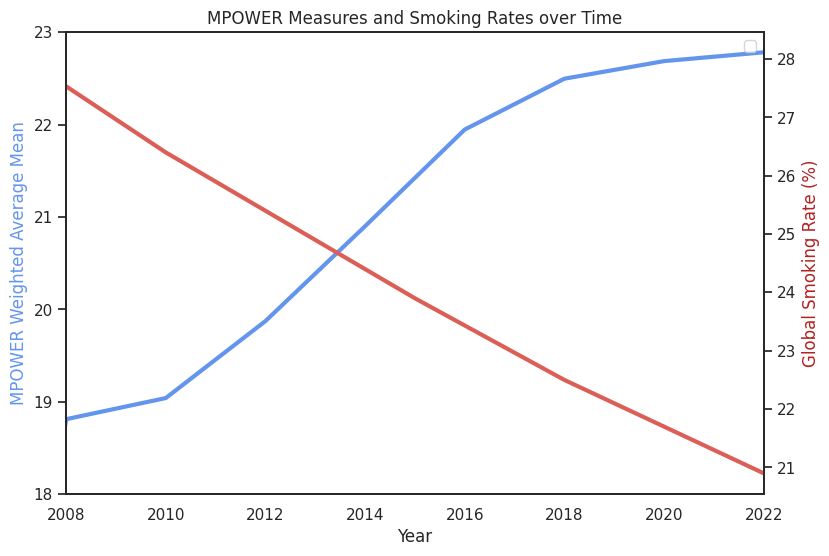

<Figure size 640x480 with 0 Axes>

In [393]:
# Create a mask to smooth the data into a line as not all years have data
ratemask = np.isfinite(cleaned_merged_rate_MPOWER["Smoking Rate"])
MPOWERmask = np.isfinite(cleaned_merged_rate_MPOWER["Weighted Mean MPOWER"])

# Create the plot and set the axis values
sns.set_theme(style="white", palette="hls")
fig, ax1 = plt.subplots(figsize=(9,6))
plt.xlim(2008, 2022)
plt.ylim(18, 23)

# Plot the MPOWER values
ax1.set_xlabel('Year')
ax1.set_ylabel('MPOWER Weighted Average Mean', color='cornflowerblue')
ax1.plot(cleaned_merged_rate_MPOWER["Weighted Mean MPOWER"][MPOWERmask], color='cornflowerblue', lw =3)
ax1.tick_params(axis ='y')


# Adding Twin Axes to plot smoking rates
ax2 = ax1.twinx()
ax2.set_ylabel('Global Smoking Rate (%)', color='firebrick')
ax2.plot(cleaned_merged_rate_MPOWER["Smoking Rate"][ratemask], lw=3)
ax2.tick_params(axis ='y')

# Adding title
plt.title('MPOWER Measures and Smoking Rates over Time')

# Show plot
plt.show()
plt.clf()

#### Conclusion
The data shows that there is a clear correlation globally between the number of measures in place to reduce demand for tobacco and the smoking rate.
This demonstrates that there is evidence that increasing the measures in place to reduce demand for tobacco products reduces smoking rates.

### Analysis Two: How have smoking rates changed in the UK

The next step in our analysis was to determine if this global trend was also seen in the UK.
Over the last twenty years there has been increasing legal measures implemented by successive UK governments to reduce the rate of smoking.
A summary of these measures are outlined below:

#### Timeline of key government legislation and regulation

<img src="https://github.com/rhobaker/Data_Project/blob/main/smoking_timeline.png?raw=true" width="950" height="450"/>

Reference: https://news.cancerresearchuk.org/2023/03/07/ending-smoking-could-free-up-gp-appointments/

Our first task was to examine how the UK smoking rate has changed overtime, so it could be compared to other factors.
To do this we took data from the ONS Smoking Habits in the UK dataset.  We restricted this to the years from 2000 to 2019 as these are the years when the majority of government intervention has been seen.

In [394]:
url = ("https://raw.githubusercontent.com/rhobaker/Data_Project/main/Cleaned_Data/smokinghabits_Table_1a-Table_1_cleaned.csv")
smokers = pd.read_csv(url)
smokers.drop(['Unnamed: 0'], axis=1, inplace=True)
#Getting relevant columns for visualisation
adults=smokers[["Year", "All 16+"]]
#Reversing the columns so that both datasets match
adults_reversed = adults.iloc[::-1]
adults_reversed
#Further qualifying the data so only data from the years 2000 is selected
adults_2000 = adults_reversed.iloc[13:33]
adults_2000 = adults_2000.reset_index()
adults_2000.drop(['index'], axis=1, inplace=True)
adults_2000.set_index("Year", inplace = True)
adults_2000.rename(columns={"All 16+": 'Smoking Rate'}, inplace=True)
# adults_2000

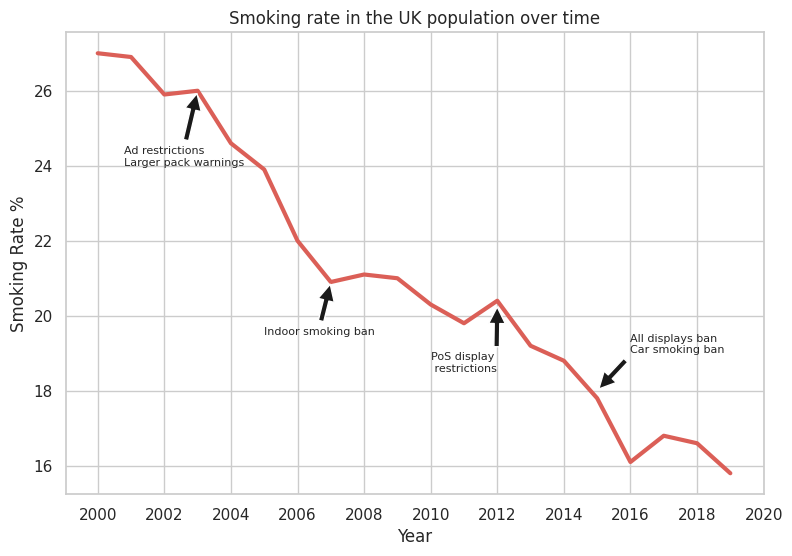

<Figure size 640x480 with 0 Axes>

In [395]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid", palette="hls")

plt.figure(figsize=(9, 6))
plt.plot(adults_2000["Smoking Rate"], lw=3)
plt.xticks([2000,2002,2004,2006,2008,2010,2012, 2014, 2016, 2018, 2020])
plt.xlabel("Year")
plt.ylabel("Smoking Rate %")
plt.title("Smoking rate in the UK population over time")

#Set annotations
x, x1, x2, x3=2003, 2007, 2012, 2015
l1, l2, l3, l4="Ad restrictions\nLarger pack warnings", "Indoor smoking ban", "PoS display\n restrictions", "All displays ban\nCar smoking ban"
aps = dict(facecolor ='k', shrink = 0.05)


plt.annotate(l1, xy =(x, 26),
                xytext =(x-2.2, 24),
                arrowprops = aps, fontsize=8)

plt.annotate(l2, xy =(x1, 20.9),
                xytext =(x1-2, 19.5),
                arrowprops = aps, fontsize=8)

plt.annotate(l3, xy =(x2, 20.3),
                xytext =(x2-2, 18.5),
                arrowprops = aps, fontsize=8)

plt.annotate(l4, xy =(x3, 18),
                xytext =(x3+1, 19),
                arrowprops = aps, fontsize=8)


plt.show()
plt.clf()

It can be seen that the smoking rate has decreased from over 25% of the population in 2000 to just under 16% in 2019.  This has co-incided with the increase in legistation as described above.  This is a reduction of around (58.89m x 27%) 15.9 million people in 2000 to (66.80m x 15.8%) around 10.6 million people in 2019, a fall of around 5.3 million people.

Ref: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatestimeseriesdataset

Our next step was to analyse what factors may be involved in this decline, in order to predict how any future changes may impact on this trend in the smoking rate.

## Analysis Three: Financial factors affecting smoking prevalence

One of the ways in which governments have attempted to reduce smoking rates is through raising taxes on tobacco.\
The analysis below shows how taxation on tobacco has changed to in an attempt to curb smoking. Below is an analysis of the average price of a King size pack ( 20 cigarette pack) since 2000 to now and the change in taxation during this time. Important note: pre 20 May 2017, cigarette ad valorem (%) and specific £ per 1000 sticks were used to calculate duty. Post 20 May 2017, the excise duty on cigarettes is equal to the higher of either the specific £ per 1000 sticks plus 16.5% of retail price or the minimum excise tax £ per 1000 sticks.

In addition to this, we analysed NHS publicly available datasets on the affordability of tobacco in England to see how this increase in tax has impacted impacted on the affordability of tobacco products.

In [396]:
price_url = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/Cleaned_Data/Cleaned_ONS_av_price_cigarettes_king_size_filterce_cigarettes_king_size.csv'
price = pd.read_csv(price_url)

In [397]:
# Extract the first year from the 'Year' column and convert to integer
vat['Start Year'] = vat['Year'].str.split('-').str[0].astype(int)
vat = vat[vat['Start Year'] >= 2000].reset_index()
vat = vat.drop(columns=['index', 'level_0'])

In [398]:
# Strip the last character from the 'standard' column at index 8 and 9
for index in [8, 9]:
    if vat.at[index, 'Standard'].endswith('f'):
        vat.at[index, 'Standard'] = vat.at[index, 'Standard'][:-1]

In [399]:
price['Price in £'] = price['Pence'] / 100
price = price[price['year'] >= 2000].reset_index()
price = price.drop(columns=['index'])

In [400]:
# Ensure 'Date' columns are datetime types
# Ensure 'Date of change' columns are datetime types without converting parsing errors to NaT
pre_may_2017_df['Date of change'] = pd.to_datetime(pre_may_2017_df['Date of change'], format='%Y-%m-%d')
post_may_2017_df['Date of change'] = pd.to_datetime(post_may_2017_df['Date of change'], format='%Y-%m-%d')

In [401]:
#Combine the two dataframes
combined_df = pd.concat([pre_may_2017_df, post_may_2017_df]).sort_values(by='Date of change').reset_index(drop=True)

In [402]:
# Convert 'Date of change' to datetime format
combined_df['Date of change'] = pd.to_datetime(combined_df['Date of change'])

# Drop rows where the year is earlier than 2000
combined_df = combined_df[combined_df['Date of change'].dt.year >= 2000].reset_index()

In [403]:
# Extract year from 'Date of change' column in combined_df
combined_df['Year'] = combined_df['Date of change'].dt.year

# Merge price with combined_df based on year and align prices
combined_df = combined_df.merge(price, how='left', left_on='Year', right_on='year')

# Create 'Retail price of King size pack in £' column
combined_df['Retail price of King size pack in £'] = np.where(combined_df['Year'] == combined_df['year'], combined_df['Price in £'], np.nan)

combined_df.drop(columns=['year', 'Price in £', 'Pence', 'Year'], inplace=True)

In [404]:
# Extracting year from 'Date of change' in combined_df
combined_df['When'] = combined_df['Date of change'].dt.year

# Merging combined_df and VAT
combined_df = combined_df.merge(vat, how='left', left_on='When', right_on='Start Year')

# Creating 'VAT' column based on condition
combined_df['VAT'] = np.where(combined_df['When'] == combined_df['Start Year'], combined_df['Standard'], np.nan)

In [405]:
# Dropping unnecessary columns
combined_df.drop(columns=['When', 'Start Year', 'Standard', 'index', 'Year'], inplace=True)


In [406]:
def calculate_duty(date, cigarettes_per_pack):

    # Get the retail price for the given date
    retail_price = combined_df.loc[combined_df['Date of change'] == date, 'Retail price of King size pack in £'].iloc[0]
    # Check if the retail price is NaN
    if pd.isna(retail_price):
        return np.nan
    if date < pd.to_datetime('2017-05-20'):
        # Historical duty pre-May 2017
        if not pre_may_2017_df.empty:
            pre_may_rows = pre_may_2017_df[pre_may_2017_df['Date of change'] <= date]
            if not pre_may_rows.empty:
                row = pre_may_rows.iloc[-1]
                specific_duty_per_pack = (row['Specific £ per 1000 sticks'] / 1000) * cigarettes_per_pack  # Adjusted duty for a pack
                ad_valorem_percentage = pd.to_numeric(row['Cigarettes ad valorem (%)'], errors='coerce')
                # Calculate the percentage duty for a pack
                percentage_duty = (ad_valorem_percentage / 100) * retail_price
                # Total duty for a pack
                total_duty = percentage_duty + specific_duty_per_pack
            else:
                total_duty = 0  # No historical data available
        else:
            total_duty = 0  # No historical data available
    else:
        # Duty post-May 2017
        if not post_may_2017_df.empty:
            post_may_rows = post_may_2017_df[post_may_2017_df['Date of change'] <= date]
            if not post_may_rows.empty:
                row = post_may_rows.iloc[-1]
                specific_duty_per_pack = (row['Specific £ per 1000 sticks'] / 1000) * cigarettes_per_pack  # Adjusted duty for a pack
                minimum_excise_tax_per_pack = (row['Minimum excise tax £ per 1000 sticks'] / 1000) * cigarettes_per_pack  # Adjusted column name here
                ad_valorem_percentage = pd.to_numeric(row['Cigarettes ad valorem (%)'], errors='coerce')
                # Calculate the percentage duty for a pack
                percentage_duty = (ad_valorem_percentage / 100) * retail_price
                # Total duty for a pack using specific duty plus percentage
                total_duty_1 = percentage_duty + specific_duty_per_pack
                # Total duty for a pack using minimum excise tax
                total_duty_2 = minimum_excise_tax_per_pack
                # Take the higher of the two total duties
                if total_duty_1 > total_duty_2:
                    total_duty = round(total_duty_1, 2)
                else:
                    total_duty = round(total_duty_2, 2)
            else:
                total_duty = 0  # No post-May 2017 data available
        else:
            total_duty = 0  # No post-May 2017 data available
    return round(total_duty,2)

In [407]:
combined_df['Duty'] = combined_df['Date of change'].apply(lambda x: calculate_duty(x, 20))

In [408]:
combined_df['VAT Amount'] = round((combined_df['Retail price of King size pack in £'] / (1 + (pd.to_numeric(combined_df['VAT'], errors='coerce')/100))) * (pd.to_numeric(combined_df['VAT'], errors='coerce')/100),2)

In [409]:
combined_df['Total tax'] = round(combined_df['Duty'] + combined_df['VAT Amount'],2)

In [410]:
combined_df

,Date of change,Cigarettes ad valorem (%),Specific £ per 1000 sticks,Minimum excise tax £ per 1000 sticks,Retail price of King size pack in £,VAT,Duty,VAT Amount,Total tax
0,2000-03-21,22.0,90.43,NaN,4.02,17.5,2.69,0.60,3.29
1,2001-03-07,22.0,92.25,NaN,4.17,17.5,2.76,0.62,3.38
2,2002-04-17,22.0,94.24,NaN,4.19,17.5,2.81,0.62,3.43
3,2003-04-09,22.0,96.88,NaN,4.29,17.5,2.88,0.64,3.52
4,2004-03-17,22.0,99.80,NaN,4.45,17.5,2.98,0.66,3.64
5,2005-03-16,22.0,102.39,NaN,4.65,17.5,3.07,0.69,3.76
6,2006-03-22,22.0,105.10,NaN,4.83,17.5,3.16,0.72,3.88
7,2007-03-21,22.0,108.65,NaN,5.05,17.5,3.28,0.75,4.03
8,2008-03-12,22.0,112.07,NaN,5.37,17.5,3.42,0.80,4.22
9,2008-11-24,24.0,112.07,NaN,5.37,17.5,3.53,0.80,4.33


#####As the table above shows, there are different government taxes on cigarettes which have increased the tax burden per a pack of cigarettes. This largely affects the consumer and the tobacco companies. Over the years, VAT has increased, and the government introduced 'Minimum excise tax £ per 1000 sticks' to erase any loopholes that reduced tax.

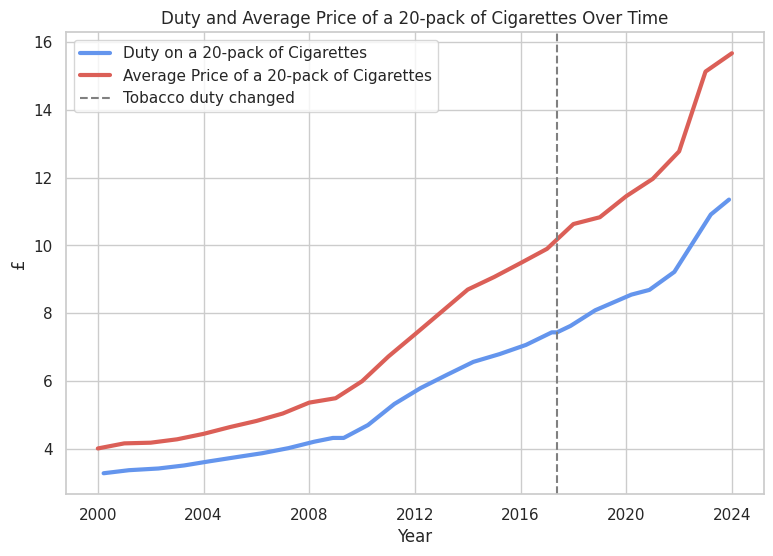

In [411]:
# Convert 'Date of change' to datetime
combined_df['Date of change'] = pd.to_datetime(combined_df['Date of change'])

# Convert 'year' to datetime format with only year
price['year'] = pd.to_datetime(price['year'], format='%Y')

plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid", palette="hls")

# Plotting the duty on a 20-pack of cigarettes
plt.plot(combined_df['Date of change'], combined_df['Total tax'], label='Duty on a 20-pack of Cigarettes', color='cornflowerblue', lw=3)

# Plotting the average price of a 20-pack of cigarettes
plt.plot(price['year'], price['Price in £'], label='Average Price of a 20-pack of Cigarettes', lw=3)

# Adding a vertical line for duty change
annotation_date = pd.to_datetime('2017-05-20')
plt.axvline(x=annotation_date, color='grey', linestyle='--', label='Tobacco duty changed')

plt.xlabel('Year')
plt.ylabel('£')
plt.title('Duty and Average Price of a 20-pack of Cigarettes Over Time')
plt.legend()

plt.show()

#### Import NHS affordability of tobacco dataset

In [412]:
afford_url = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/Cleaned_Data/Table_S.3.1-Table_1_cleaned.csv'

affordability = pd.read_csv(afford_url)
affordability.drop(['Unnamed: 0'], axis=1, inplace=True)
#Getting relevant columns for visualisation
affordability=affordability[["Year","Tobacco Price Index", "Retail Price Index", "Tobacco Affordability Index"]]
#Further qualifying the data so only data from the years 2000 is selected
affordability_2000 = affordability.iloc[13:33]
affordability_2000.set_index("Year", inplace = True)
# affordability_2000

These numbers show that in the years from 2000 to 2019 the price of tobacco (the Tobacco Price Index) has increased by 190% ((786.1-270.4)/270.4).  In comparison, the price of other goods has only increased by 70% ((288.8-170.3)/170.3).  As a result tobacco has become 28% less affordable ((93.7-67.3)/93.7).

To analyse these numbers further, we have compared the affordability of tobacco to the smoking rate.

In [413]:
#Getting relevant columns for visualisation
adults=smokers[["Year", "All 16+"]]
#Reversing the columns so that both datasets match
adults_reversed = adults.iloc[::-1]
adults_reversed
#Further qualifying the data so only data from the years 2000 is selected
adults_2000 = adults_reversed.iloc[13:33]
adults_2000 = adults_2000.reset_index()
adults_2000.drop(['index'], axis=1, inplace=True)
adults_2000.set_index("Year", inplace = True)
#adults_2000


In [414]:
expend_url = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/Cleaned_Data/Table_S.3.2-Table_1_cleaned.csv'
expenditure = pd.read_csv(expend_url)
expenditure.drop(['Unnamed: 0'], axis=1, inplace=True)
expenditure.set_index("Year", inplace = True)
#expenditure

In [415]:
# Merge datasets
merged_datasets = pd.DataFrame(pd.merge(adults_2000, affordability_2000, left_index=True, right_index=True, how='inner'))
merged_datasets.rename(columns={"All 16+": 'Smoking Rate'}, inplace=True)
merged_all_datasets = pd.DataFrame(pd.merge(merged_datasets, expenditure, left_index=True, right_index=True, how='inner'))

### Affordability and Proportion of Smokers

In [416]:
#Correlation coefficient
smoke_rate_afford_corr = np.corrcoef(merged_datasets["Smoking Rate"], merged_datasets["Tobacco Affordability Index"])
smoke_rate_afford_corr

array([[1.        , 0.84144322],
       [0.84144322, 1.        ]])

There is a strong correlation between the affordability of tobacco and the smoking rate.  As tobacco becomes less affordable, the smoking rate decreases.

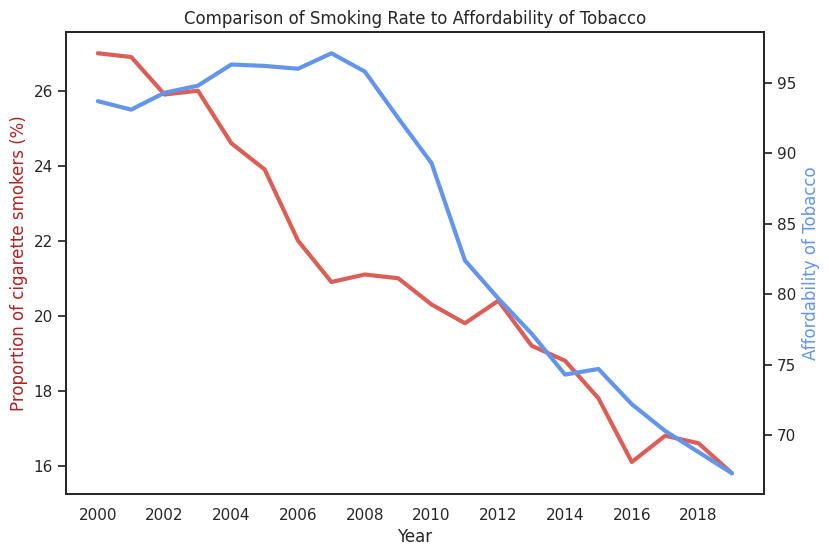

<Figure size 640x480 with 0 Axes>

In [417]:
#Create a visualisation to compare the proportion of cigarette smokers vs the affordability of tobacco
sns.set_theme(style='white',palette='hls')
fig, ax3 = plt.subplots(figsize=(9,6))
plt.title("Comparison of Smoking Rate to Affordability of Tobacco")
ax3.set_xlabel("Year")
ax3.set_ylabel("Proportion of cigarette smokers (%)", color='firebrick')
ax3.tick_params(axis='y')
# Plot smoking rate
plt.plot(merged_all_datasets['Smoking Rate'], lw=3)
plt.xticks([2000,2002,2004,2006,2008,2010,2012,2014,2016,2018])

# Adding Twin Axes to plot smoking rates
ax4 = ax3.twinx()
ax4.set_ylabel("Affordability of Tobacco", color='cornflowerblue')
plt.plot(merged_all_datasets['Tobacco Affordability Index'], lw=3, color='cornflowerblue')
ax4.tick_params(axis='y')

# Show plot
plt.show()
plt.clf()

The proportion of cigarette smokers has generally decreased at a relatively steady rate, while the afforability of tobacco is more volatile as it responds to external economic factors.

To understand the impact on household expenditure, we also compared the smoking rate to the percentage of household expenditure spent on tobacco.

In [418]:
#Correlation coefficient
smoke_rate_exp_corr = np.corrcoef(merged_all_datasets["Smoking Rate"], merged_all_datasets["Tobacco Expenditure (%)"])
smoke_rate_exp_corr

array([[1.        , 0.88856459],
       [0.88856459, 1.        ]])

This also shows a clear correlation between the percentage of household expenditure and the declining smoking rate, even as the price of cigarettes increases significantly more than the retail price index.

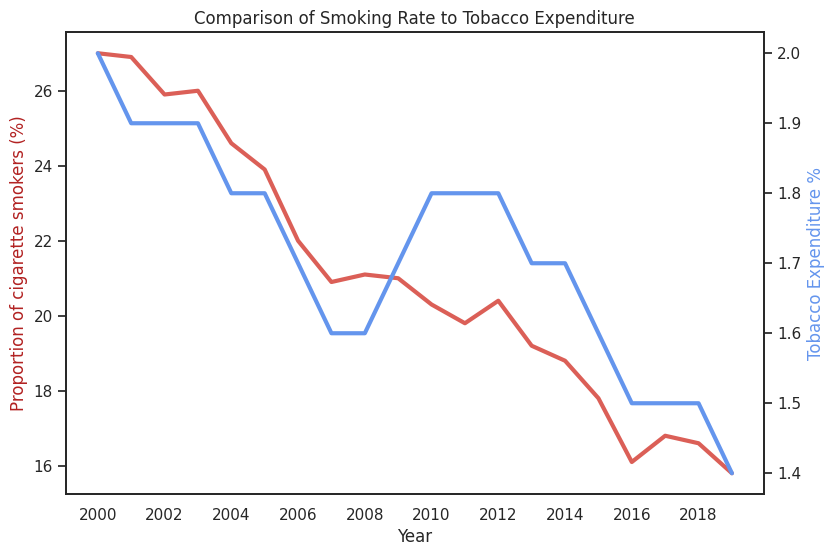

<Figure size 640x480 with 0 Axes>

In [419]:
#Create a visualisation to compare the proportion of cigarette smokers vs the expenditure on tobacco
sns.set_theme(style="white", palette="hls")
fig, ax5 = plt.subplots(figsize=(9,6))
plt.title("Comparison of Smoking Rate to Tobacco Expenditure")
ax5.set_xlabel("Year")
ax5.set_ylabel("Proportion of cigarette smokers (%)", color='firebrick')
# Plot smoking rate
plt.plot(merged_all_datasets['Smoking Rate'], lw=3)


ax5.tick_params(axis='y')
plt.xticks([2000,2002,2004,2006,2008,2010,2012,2014,2016,2018])

# Adding Twin Axes to plot smoking rates
ax6 = ax5.twinx()
ax6.set_ylabel("Tobacco Expenditure %", color='cornflowerblue')
plt.plot(merged_all_datasets['Tobacco Expenditure (%)'], lw=3, color="cornflowerblue")
ax6.tick_params(axis='y')

# Show plot
plt.show()
plt.clf()

As with the affordability of tobacco, the expenditure on tobacco appears to be more affected by external factors. Of note is the sharp rise in expenditure from 2008 to 2010, before it begins to fall again from 2012. The most obvious external factor that could affect the UK in 2008 is the recession. This may suggest that those that currently smoked would have an increased tobacco usage during times of stress.

## Conclusions

+ The data showcases a sharp rise in both taxes and the average price of a King size pack.
+ From the data, it can be inferred that this has a two-fold effect on smoking. Firstly, it deters heavy smoking due to the financial burden regular and excessive smoking incurs. Secondly, the lower profit margin as well as the social stigma towards smoking makes the tobacco industry less appealing for investors.
+ A relatively steady decline in the proportion of smokers in the UK can be seen dating back to 2000.
+ The affordability of tobacco has also decreased but is somewhat more volatile and appears to respond to external economic factors. In cases where tobacco is relatively affordable, there is no comparable increase or more limited reduction in the proportion of smokers.
+ Household expenditure on tobacco does not reduce at the same rate as the proportion in smokers. We can in fact see an increase in tobacco expenditure from 2008 - 2010, co-inciding with the "credit crunch" and recession in 2008 and 2009, despite both the continued reduction of the number of smokers and a sharp drop in tobacco affordability. This suggests that reducing the affordability of tobacco is of limited effectiveness as a measure to reduce the amount of tobacco consumed by those who are pre-existing smokers.
+ Increasing the price of tobacco is potentially most effective as a deterrant to prevent people from taking up smoking as a habit. It is of limited effectiveness as a tool to help people quit smoking.


## Analysis Four: Changes in e-cigarette use

The proposed ban focuses on reducing smoking rates, but also acknowledges the issue of the use of e-cigarettes (a.k.a. vaping). E-cigarettes don't contain tobacco, the key factor causing cancer, they are not risk-free. Although their use is important tool for a less harmful alternative to smoking and tool for quitting, there are concerns of the rate rising to a concerning level, particularly in young people. The NHS recommends that young people should not take up vaping, concerned that vape 'flavours' such as fruit and sweets are more attractive to young people. The long-term side-effects of vaping are still unknown.

We analysed e-cigarette rates using ONS datasets, looking at different age group demographics.  

#### E-cigarette use by age category


In [420]:
#Import vaping dataset
url = ("https://raw.githubusercontent.com/rhobaker/Data_Project/main/Cleaned_Data/ecig_table1abc_cleaned.csv")

vapers = pd.read_csv(url)

vapers.drop(['Unnamed: 0'], axis=1, inplace=True)

# vapers.head()

In [421]:
#Vapers by age category
vapers_ages = vapers[["Year", "All 16-24", "All 25-34", "All 35-49", "All 50-59", "All 60+"]]

#Rename columns for better labels in vis
columns = ['Year', '16-24', '25-34', '35-49', '50-59', '60+']
vapers_ages.columns = columns

#Convert data to long format for seaborn visualisation
v_ages_melt = pd.melt(vapers_ages, id_vars="Year")
v_ages_melt.head()

#Clean up long table
v_ages_melt.rename(columns={"variable": "Age_group", "value": "Proportion"}, inplace=True)
# v_ages_melt.head()

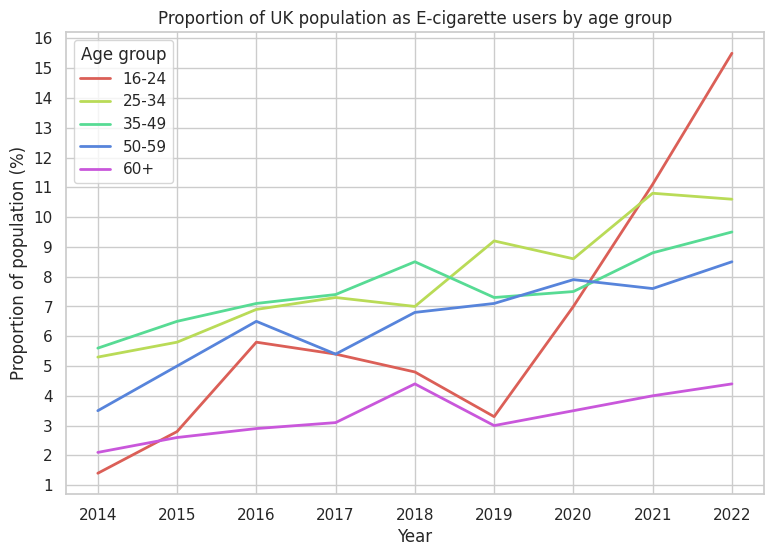

<Figure size 640x480 with 0 Axes>

In [422]:
#Multi-line plot on e-cig use over time by age group
sns.set_theme(style="whitegrid")
plt.figure(figsize=(9, 6))
ax7 = sns.lineplot(x='Year', y='Proportion', hue='Age_group', data=v_ages_melt, lw=2, palette='hls')

ax7.set(xlabel='Year',
       ylabel='Proportion of population (%)',
       title='Proportion of UK population as E-cigarette users by age group',)

ax7.set_yticks(range(1,17))
ax7.set_yticklabels(range(1,17))

plt.legend(title='Age group')
plt.show()
plt.clf()

We can see that in all age groups, the e-cigarette usage rate has been increasing over time. Analysing by age group, we can see that:
- Ages 35-59 increase steadily
- Ages 25-34 increases more quickly over time
- Ages 60+ doesn't show much growth, showing that vaping is much less popular with the older generation.
- Post 2019 we can see a dramatic increase in the 16-24 age group; where previously this demographic had a lower use than most of the other age categories, there is an extreme growth in the rate.  

Let's compare e-cigarette rates to smoking rates between age groups to see if there are any patterns, taking a snapshot from the most recent year in the data (2022):

#### E-cigarette vs smoking prevalence by age category

In [423]:
#Extract smokers ages
smokers_ages = smokers[['All 16-24', 'All 25-34', 'All 35-49', 'All 50-59', 'All 60+']]
#Rename columns for better labels in later vis
columns = ['16-24', '25-34', '35-49', '50-59', '60+']
smokers_ages.columns = columns
#Extract just 2022 smokers
smoke22 = smokers_ages.loc[0].to_frame()
#Clean up dataframe
smoke22.insert(0, 'Type', 'Smokers')
smoke22.reset_index(inplace=True)
smoke22.rename(columns={"index": "Age_group", 0: "Proportion"}, inplace=True)
# smoke22.head()

#Extract just 2022 vapers
vape22 = vapers_ages.loc[0].to_frame()
#Clean up dataframe
vape22.insert(0, 'Type', 'Vapers')
vape22.reset_index(inplace=True)
vape22.rename(columns={"index": "Age_group", 0: "Proportion"}, inplace=True)
vape22.drop(0, axis='index', inplace=True)
# vape22.head()

#Combine vaper and smoker dfs
combined22 = pd.concat([smoke22, vape22], ignore_index=True)
# combined22.head()

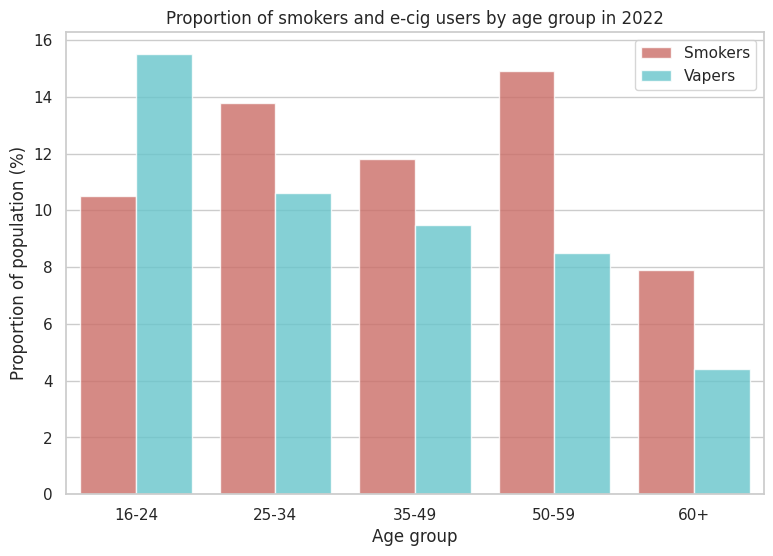

<Figure size 640x480 with 0 Axes>

In [424]:
#Bar plot of smoking and e-cig use by age group in 2022
sns.set_theme(style="whitegrid")
plt.figure(figsize=(9, 6))
ax8 = sns.barplot(combined22, x="Age_group", y="Proportion", hue="Type", palette='hls', alpha=0.8)

ax8.set(xlabel='Age group',
       ylabel='Proportion of population (%)',
       title='Proportion of smokers and e-cig users by age group in 2022',)

ax8.legend_.set_title(None)
plt.show()
plt.clf()

Here we can see that smoking rates do not have a clear correlation to vaping rates between age groups. Smoking rates vary between age groups, but vaping has a clear trend of higher use the younger the age group. Therefore younger people are likely to have a higher usage because of the attractiveness of vaping, not just as a tool to quit smoking as their smoking rates are lower than most of the other age groups.

#### E-cigarette device type in youths 17 and under

One of the key concerns in recent years is the rise in disposable vapes, particularly their use by young people. The UK government plans to ban these as part of the proposed bill, with Scotland having a confirmed date of banning disposable vapes from 1 April 2025. Although we do not have a recent dataset to be able to analyse general e-cigarette rates in young people under 17, we can reliably extract a small amount of data from the Ash smokefree GB youth survey report to look at device type use in this age category.

In [425]:
#Import e-cig device type data
url = ("https://raw.githubusercontent.com/rhobaker/Data_Project/main/Cleaned_Data/Most_freq_used_e-cig_by_device_type_gb_youth.csv")
disposable = pd.read_csv(url)
# disposable.head()

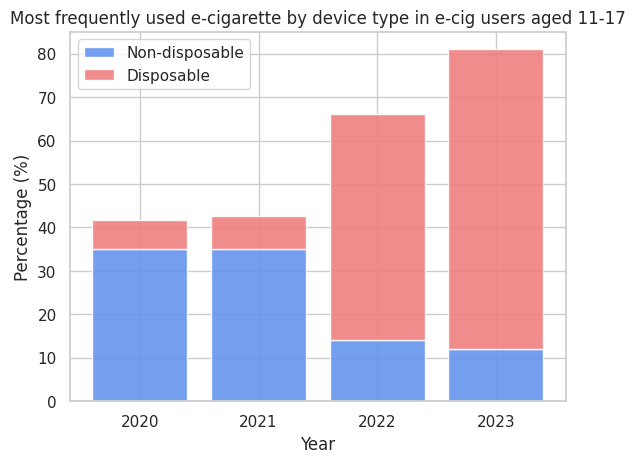

<Figure size 640x480 with 0 Axes>

In [426]:
#Stacked bar plot for e-cig use by device
sns.set_theme(style="whitegrid")

x = disposable['Year']
y1 = disposable['Non-disposable']
y2 = disposable['Disposable']

plt.bar(x, y1, color='cornflowerblue', alpha=0.9)
plt.bar(x, y2, bottom=y1, color='lightcoral', alpha=0.9)

plt.xticks([2020, 2021, 2022, 2023])
plt.legend([])

plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.title("Most frequently used e-cigarette by device type in e-cig users aged 11-17")
plt.legend(['Non-disposable', 'Disposable'])
plt.show()
plt.clf()

#### Conclusion

Although evidence shows that government mitigations are effective in bringing down smoking rates, the rise in e-cigarette use is a concern. A steady rise in use as expected as smoking rates decrease and e-cigarettes are used as quitting tools or less harmful alternatives to smoking. However the very sharp increase of e-cigarette use in younger people is far above the expected rate, considerably higher than the recent smoking rate in this demographic. Government mitigations on vaping should therefore be focussed on young people; without mitigations the rate of vaping in young people could rise exponentially.

The planned ban on disposable vapes is likely to reduce the e-cigarette usage rate in young people, with an overwhelming majority of those 11-17 using disposable vapes most frequently, although this will also benefit other age groups. The UK government have stated that alongside banning disposable vapes, measures will be brought forward to to restrict vape flavours, displays and packaging, to make them less attractive to children. Our MPOWER analysis shows that government mitigations effectively reduced smoking rates by including measures on displays and advertising, therefore this ban is likely to be effective and curb the rise in the vaping rate in young people by introducing restrictions in these areas, particularly as vaping flavours and colours are more attractive to younger people.

## Analysis Five - Identify non-government intervention factors that may impact on smoking rates

Although smoking rates correlate with factors such as affordability and e-cigarette use that the government may have some control over, smoking rates are also potentially influenced by other factors.

To identify these we analysed the changes in smoking habits from 2014 to 2022, to determine if other factors could be influencing the rates.

The first variable we looked at was to see if there were any differences between smoking rates for people with different levels of education.


In [427]:

# Convert percentage columns to numeric
percentage_columns = [
    '2022_Current_smokers_%', '2022_Current_smokers_LCL', '2022_Current_smokers_UCL',
    '2022_Ex-smokers_%', '2022_Ex-smokers_LCL', '2022_Ex-smokers_UCL',
    '2022_Never_smoked_%', '2022_Never_smoked_LCL', '2022_Never_smoked_UCL'
]

for col in percentage_columns:
  data_2022[col] = pd.to_numeric(data_2022[col], errors='coerce')

# Check for missing data
missing_data_summary = data_2022.isnull().sum()
# print(missing_data_summary)
data_2022 = data_2022[data_2022.Country.isin(["United Kingdom"])]
# data_2022

In [428]:
# Select data to merge
data_to_merge = pd.DataFrame(data_2022[["Highest_level_of_education",'2022_Current_smokers_%']])
data_to_merge.set_index(["Highest_level_of_education"], inplace = True)
levels_df = pd.DataFrame(total_pop_df)
# merge data together
merged_qual_data = pd.merge(levels_df, data_to_merge, left_index=True, right_index=True, how='outer' )
# merged_qual_data

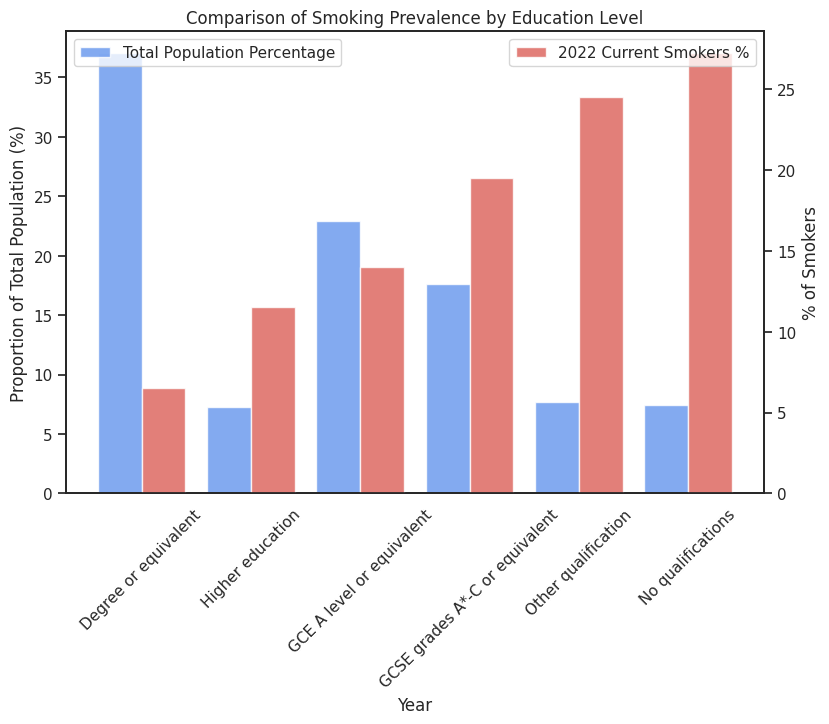

<Figure size 640x480 with 0 Axes>

In [429]:
#Create a visualisation to compare the proportion of cigarette smokers vs the expenditure on tobacco
# Set the theme
sns.set_theme(style="white", palette = "hls")

# Create a figure and axis
fig, ax9 = plt.subplots(figsize=(9, 6))

# Title
plt.title("Comparison of Smoking Prevalence by Education Level")

# X-axis label
ax9.set_xlabel("Year")

# Plot the proportion of the total population
bar_width = 0.4
index = merged_qual_data.index.tolist()

# Primary y-axis: Proportion of the total population
ax9.bar(index, merged_qual_data['Total Population %'], bar_width, color="cornflowerblue", alpha=0.8, label="Total Population Percentage")
ax9.set_ylabel("Proportion of Total Population (%)")
ax9.tick_params(axis='y')

# Secondary y-axis: Smoking rates
ax10 = ax9.twinx()
ax10.bar([i + bar_width for i in range(len(index))], merged_qual_data['2022_Current_smokers_%'], bar_width, alpha=0.8, label="2022 Current Smokers %")
ax10.set_ylabel("% of Smokers")
ax10.tick_params(axis='y')

# Adjusting the x-ticks to be in the center
ax9.set_xticks([i + bar_width / 2 for i in range(len(index))])
ax9.set_xticklabels(index, rotation=45)

# Adding legends
ax9.legend(loc='upper left')
ax10.legend(loc='upper right')

# Show plot
plt.show()
plt.clf()

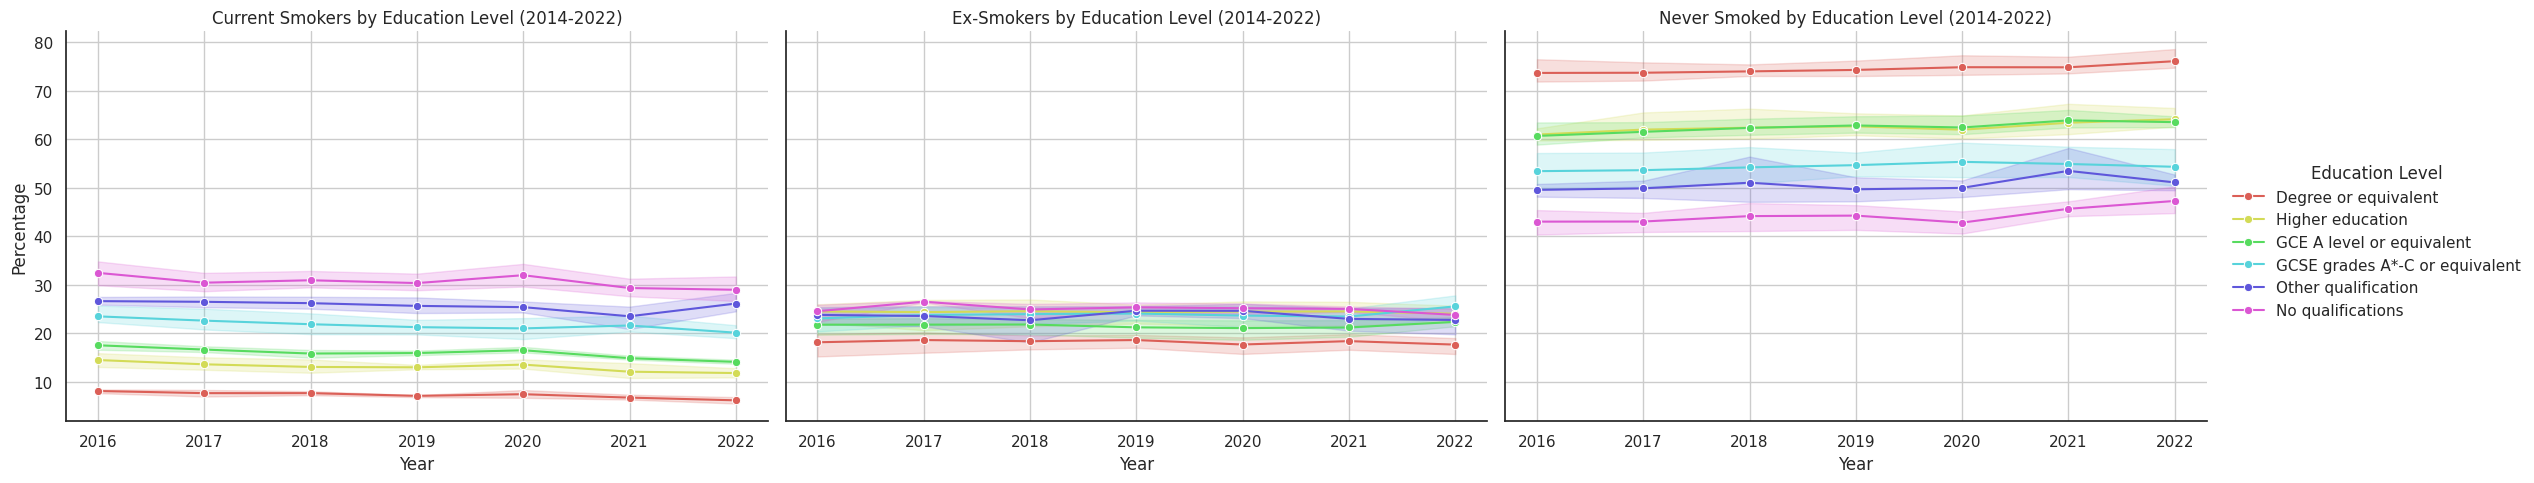

<Figure size 640x480 with 0 Axes>

In [430]:
# Filter the data to include only years from 2016 to 2022
data_filtered = data_long[data_long['Year'].between(2016, 2022)]

# Prepare the data for facet grid
data_long_melted = data_filtered.melt(
    id_vars=['Year', 'Highest_level_of_education'],
    value_vars=smoking_statuses,
    var_name='Smoking_Category',
    value_name='Percentage'
)

# Create a facet grid for the smoking categories
g = sns.FacetGrid(data_long_melted, col='Smoking_Category', hue='Highest_level_of_education', col_order=smoking_statuses, height=5, aspect=1.5)
g.map(sns.lineplot, 'Year', 'Percentage', marker='o')
g.add_legend(title='Education Level')

# Set the titles for each facet
facet_titles = {
    'Current_smokers_%': 'Current Smokers by Education Level (2014-2022)',
    'Ex-smokers_%': 'Ex-Smokers by Education Level (2014-2022)',
    'Never_smoked_%': 'Never Smoked by Education Level (2014-2022)'
}

# Enable grid lines and set titles
for ax in g.axes.flat:
    ax.grid(True)  # Enable grid lines
    title_key = ax.get_title().split('=')[1].strip()
    ax.set_title(facet_titles.get(title_key, title_key))

plt.show()
plt.clf()

Conclusion of Smoking Habits by Education Level

**1. Current Smokers by Education Level**


- Individuals with lower educational attainment tend to have higher smoking rates. This could be due to a variety of socio-economic factors, including limited access to health education and resources.
Conversely, those with higher education levels generally show higher education often correlates with greater health awareness and healthier lifestyles.

**2. Ex-Smokers by Education Level**


- Generally, individuals with higher educational attainment are more likely to have quit smoking. This might reflect better access to smoking cessation programs and greater health literacy.
Lower education levels show a smaller percentage of ex-smokers, suggesting challenges in quitting smoking, possibly due to socio-economic factors and limited access to support resources.

**3. Never Smoked by Education Level**

- The percentage of individuals who have never smoked generally mirrors the trend observed in current smokers, with higher rates in those with higher education levels.

**To summarise:**

- The three charts collectively highlight the impact of education on smoking behaviours. These patterns underscore the importance of education as a determinant of health behaviours and suggest that public health interventions aiming to reduce smoking prevalence may benefit from focusing on educational initiatives and targeted support for lower education groups.

- Addressing socio-economic disparities and enhancing access to health education and smoking cessation resources could further help in reducing smoking rates across all education levels.


**Insights for the future:**

Effectiveness of Public Health Efforts:

- The overall decline in current smoking rates and the increase in ex-smokers indicate that public health efforts are making a positive impact. However, the persistent disparities between education levels highlight the need for more targeted interventions.

Preventive Measures:

- Emphasising preventive measures in education, particularly in lower education groups, could help reduce the initiation of smoking. This includes integrating comprehensive smoking prevention programs into school curriculum and community outreach initiatives.

## Predicting future smoking rates

Using our historic data on overall smoking prevalence rates from the ONS, we can use machine learning to implement a simple linear regression model. We don't have the advanced techniques to fully evaluate our model, but the linear regression will give us a rough estimation of future smoking rates based on the current trends and mitigations.


In [431]:
#Some re-formatting of previous dfs
adults_2000 = adults.loc[0:22]
adults_2000.rename(columns={"All 16+": "Smoking Rate"}, inplace=True)
# adults_2000.head()

<ipython-input-431-4eeb9b017014>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adults_2000.rename(columns={"All 16+": "Smoking Rate"}, inplace=True)


In [432]:
#Selecting variables
x = adults_2000['Year'] #independent variable
y = adults_2000['Smoking Rate'] #dependent variable
# Test scatter of variables
# plt.scatter(x,y)

In [433]:
#sklearn needs a 2D array to work, not 1D
#Reshape variables to 2D

x = np.array(x).reshape(-1,1)
y = np.array(y).reshape(-1,1)

In [434]:
#Split data for training and testing
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [435]:
#Create model and train the model with training sets
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [436]:
#Briefly evaluate model's performance

#Get the R^2 value, which describes how well the linear regression model fits the data points, the closer to 1 the better.
print(model.score(x_test,y_test))

# > 0.9, strong R^2 score.

0.9184764364800353


In [437]:
#Use testing set to create predictions
y_pred = model.predict(x_test)

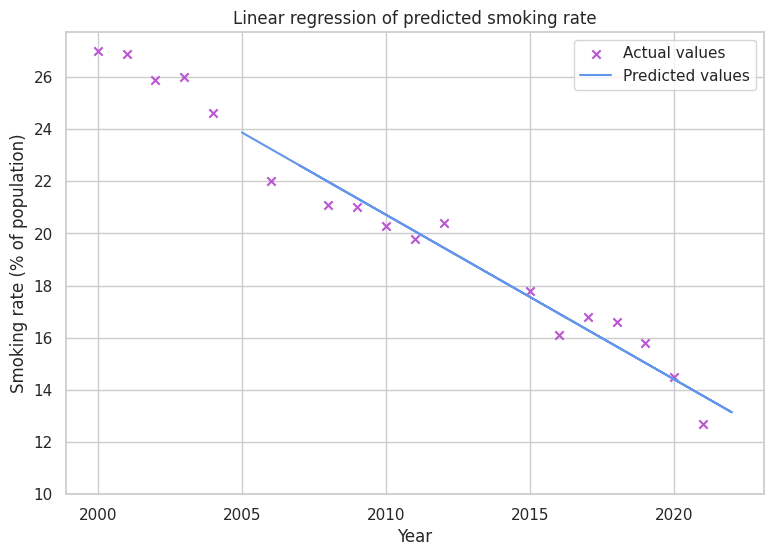

<Figure size 640x480 with 0 Axes>

In [438]:
#Plot the linear regression
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid", palette="hls")
plt.scatter(x_train, y_train,color='mediumorchid', marker="x", label="Actual values")
plt.plot(x_test, y_pred,color='cornflowerblue', label="Predicted values")
plt.xlabel("Year")
plt.ylabel("Smoking rate (% of population)")
plt.yticks(range(10, 28, 2))
plt.xticks(range(2000, 2025, 5))
plt.legend()
plt.title("Linear regression of predicted smoking rate")
plt.show()
plt.clf()


In [439]:
#We can see that our algorithm is working correctly. We can now input values to the model to make predictions.

# Create a list of rate predictions for future years up to 2030
# We will also include 2022 and 2023, just to fill in the gaps in our data line and account for missing data
future_years = [2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]

def predict_list(future_years):
    predict_rates = []
    for year in future_years:
        arr = np.array(year).reshape(-1,1)
        pred_year = model.predict(arr)
        predict_rates.append(pred_year[0][0].round(2))
    return predict_rates

future_rates = predict_list(future_years)
future_rates

[13.14, 12.51, 11.88, 11.25, 10.62, 9.98, 9.35, 8.72, 8.09]

In [440]:
#Make list into a dataframe and organise

f_years = pd.DataFrame(future_rates, future_years)
f_years = f_years.reset_index()
f_years.columns = ['Year', 'Smoking Rate']
f_years_reverse = f_years.iloc[::-1]


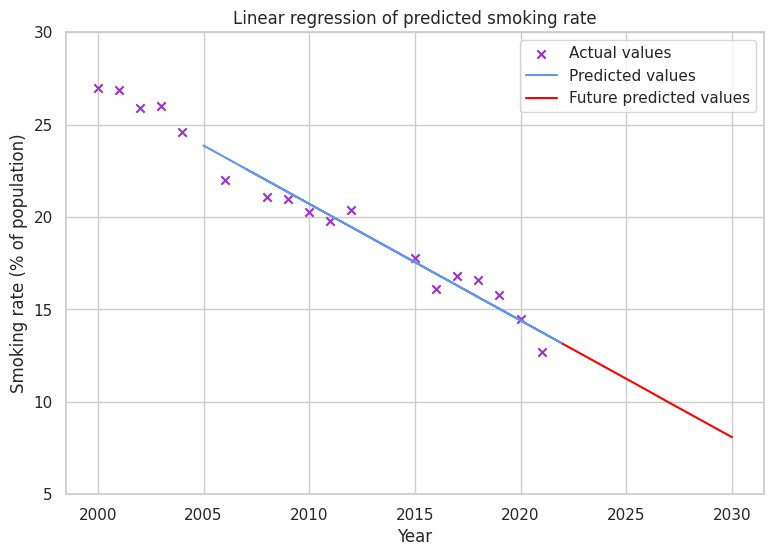

<Figure size 640x480 with 0 Axes>

In [441]:
#Plot the regression again with future predicted values
plt.figure(figsize=(9,6))
sns.set_theme(style="whitegrid", palette="hls")
plt.scatter(x_train, y_train,color='darkorchid', marker="x", label="Actual values")
plt.plot(x_test, y_pred,color='cornflowerblue', label="Predicted values")
plt.plot(future_years, future_rates, color='red', label= 'Future predicted values')
plt.xlabel("Year")
plt.ylabel("Smoking rate (% of population)")
plt.grid(True)
plt.legend()
plt.yticks(range(5, 31, 5))
plt.title("Linear regression of predicted smoking rate")
plt.show()
plt.clf()

####Conclusion:

The government's target smoking rate is to be 'smokefree' by 2030, with an overall smokinng prevalence of 5% or less. Our model roughly predicts that without any further mitigations, the smoking rate would be at 8% by 2030. With the proposed smoking ban to be enacted in 2027, it is a realistic estimation, based on looking at effects of past mitigations on the rate of decrease in the smoking rate, that the ban would cause at least an extra 1% decrease in the rate per year from 2020, allowing the goverment to reach its 'smokefree' goal by 2030.

## Overall Conclusion

Our analysis set out to answer the questions:


**How effective does historic data suggest that government mitigations have been on affecting smoking prevalence?**


**Based on this analysis, how effective will the new ban be on reducing smoking prevalence?**





Firstly, we determined that global smoking rates reduced from 28.1% in 2007 to 20.9% in 2022 and that this strongly correlated to government intervention measures increasing over the same period.

When then focused our analysis on the UK to see if it followed this global trend. We saw a similar movement in smoking rates, reducing from 27.0% in 2000 to 15.6% in 2019.  This can be seen to link with government intervention measures around packaging and advertising becoming more stringent.


As tax has significantly increased the price of cigarettes, we can see that the affordability of tobacco has decreased.  This strongly correlates with the decrease in smoking rates and from this we can infer that decreasing the affordability of tobacco by increasing taxes is linked to a reduction in the overall smoking rate.

We then looked at the impact of e-cigarettes on changes in the overall tobacco smoking rate as anecdotal evidence and our own personal experiences suggest that there has been a significant increase in e-cigarette use in the past few years.

Our analysis shows that as e-cigarette use has increased, the smoking rate has decreased, however the spike in e-cigarette use is disproportionally due to the younger generation, therefore how much impact this is having on overall smoking rates is harder to determine.

Finally we examined the available data to see if other socio-economic factors could be influencing the declining smoking rate, outside of direct government control. We could see that there was a link between education level and smoking rates; the higher the education level someone has the less likely they are to smoke. This highlights the importance of education as a determinant of health behaviours and suggests that public health interventions aiming to reduce smoking prevalence may benefit from focusing on educational initiatives and targeted support for lower education groups.

When we did a similar analysis for differences between smoking rates in men and women we could not see any similar trends, so we concluded that any future government interventions should equally consider both men and women when their implmentation is planned.

The evidence therefore suggests that smoking rates will continue to fall if the future government, elected in the July 2024 UK general election, continues to tighten legislation and increase tax in a similar way to previous ones.  Socio-economic trends influencing e-cigarette use and education levels may also impact this reduction.

Our simple machine learning model shows that without further mitigations, the smoking rate is predicted to continue to fall but is at risk of not reaching the government smokefree target by 2030. If the ban is implemented, the target could realistically be reached.